(4096, 64, 64)
(64, 64, 4096)


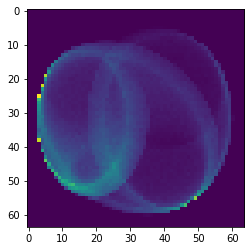

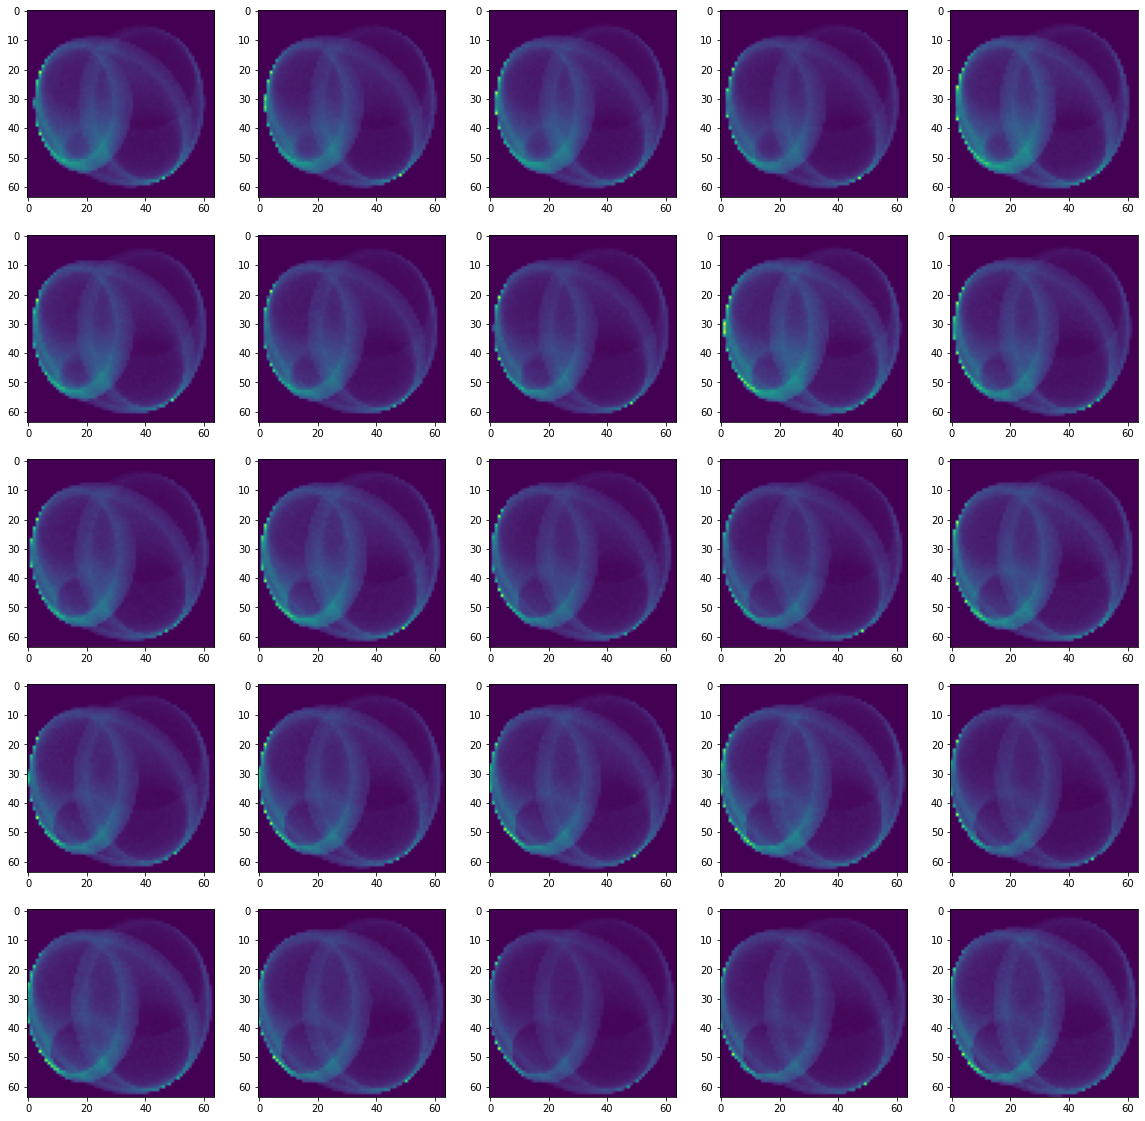

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import tal

file = "/home/mao/Documents/code/mitsuba2-transient-nlos/dataset_testZ/20230614-173842/dataset_testZ.hdf5"
n=450
x = 64
t = 4096


###OPTION 1--------------------------------------------------
# Open the hdf5 file and read the images
with h5py.File(file, 'r') as f:
    images = np.array(f['H'])
    print(images.shape)
images=np.transpose(images,(1,2,0))
                    
# ###OPTION 2------------------------------------------------                
# #Use tal to obtain npy transient images
# x = 64
# t = 4096
# data = tal.io.read_capture(data)
# voxel = tal.reconstruct.filter_H(data, 'pf', wl_mean=0.005, wl_sigma=0.005 / np.sqrt(2))
# voxel = np.transpose(voxel,(1, 2, 0))
# voxel = voxel.astype(np.float)
# print("func reconstruct")  
# voxel = np.resize(voxel, (x,x,t))
# print(voxel.shape)

data = images.astype(complex)
data_real = np.abs(data)
print(data.shape)

# Plot a single image
plt.imshow(data_real[..., n])
plt.show()

# Plot multiple images
row, col = 5, 5
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(data[..., n + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()

In [35]:
#Reduction on dimensions [64,64,4096] --> [64,64,64]

#4096 > 2048 > 1024 > 512 > 256 > 128 > 64
tmp = data
for t in range(6):
    g  = 0.5 * (tmp[:,:, ::2]  + tmp[:,:, 1::2])
    tmp = g
g.shape

(64, 64, 64)

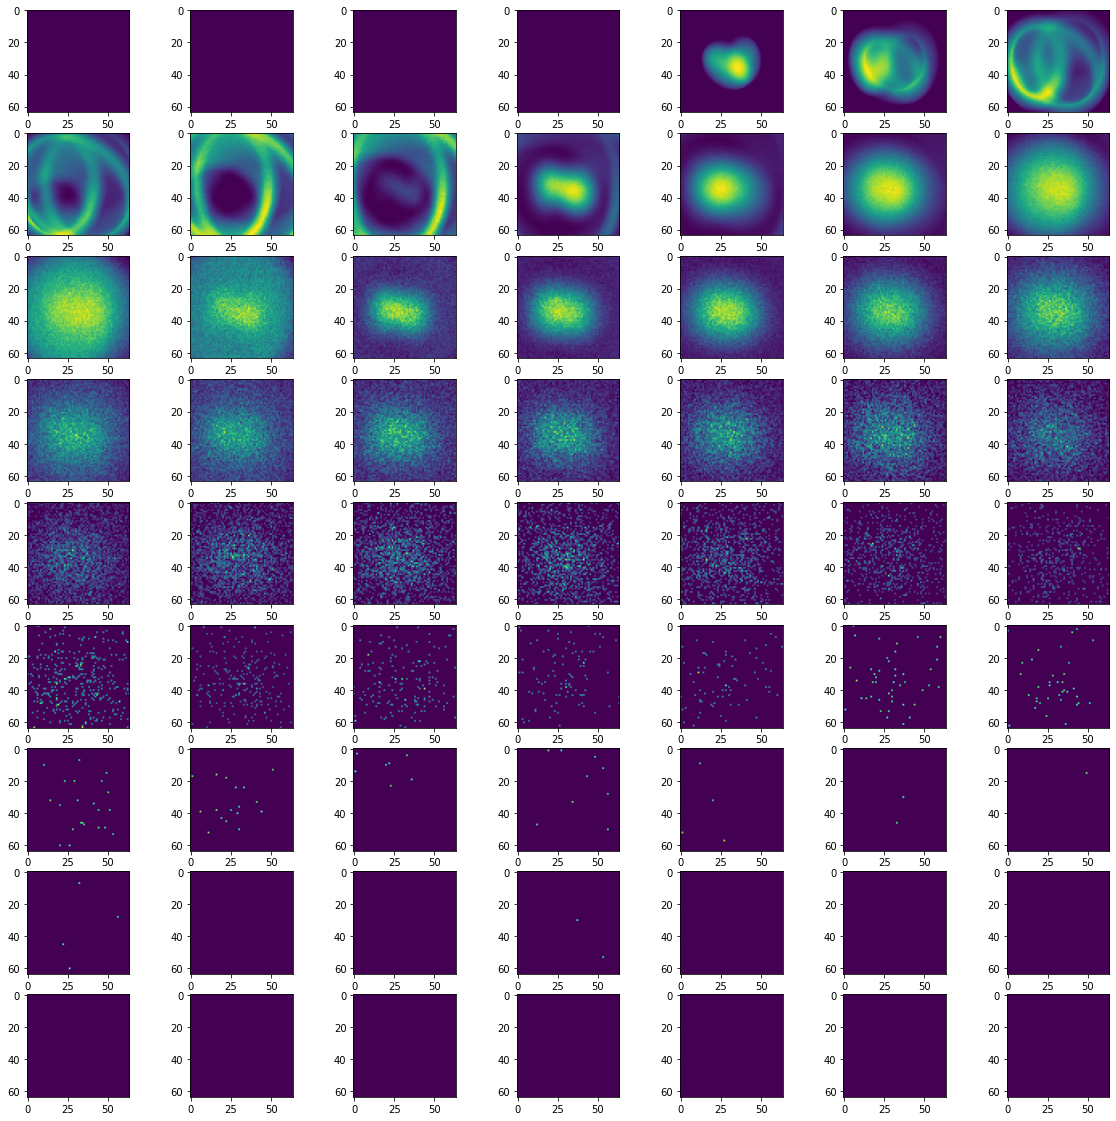

In [36]:
#PLOT WITHOUT USELESS IMAGE REDUCTION

# Plot multiple images
row, col = 9, 7
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(g[..., 0 + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()

## 2. HISTOGRAM

To visualize the pixel intensity distribution along every rendered image we plot an histogram.

Also, we need to create a function that identifies the last peak of the image, extracting the last relevant information needed.

[ 370  374  380  403  407  766  776  780  782  784  790  796  801  805
  807  848 1013 1063]
[ 370  374  380  403  407  766  776  780  782  784  790  796  801  805
  807  848 1013 1063 1092 1096 1100 1105 1114 1125 1133 1137 1142 1149
 1154 1163 1167 1175 1177 1179 1186 1190 1199 1205 1209 1214 1216 1218
 1223 1227 1233 1239 1245 1253 1257 1259 1263 1267 1271 1275 1280 1289
 1297 1304 1309 1315 1317 1322 1324 1326 1333 1340 1344 1348 1354 1358
 1362 1364 1366 1372 1377 1387 1392 1402 1412 1419 1423 1428 1430 1432
 1436 1446 1450 1460 1466 1472 1474 1476 1480 1482 1487 1489 1492 1494
 1496 1503 1508 1510 1512 1517 1519 1521 1523 1525 1533 1540 1547 1549
 1553 1557 1559 1561 1563 1568 1572 1575 1577 1579 1581 1586 1590 1592
 1597 1599 1601 1603 1605 1607 1612 1616 1624 1626 1630 1634 1638 1641
 1644 1649 1656 1658 1665 1673 1679 1684 1686 1689 1694 1701 1704 1708
 1712 1715 1717 1721 1723 1726 1728 1730 1732 1735 1737 1742 1748 1751
 1755 1758 1765 1767 1771 1780 1782 1784 1787 1789 1795

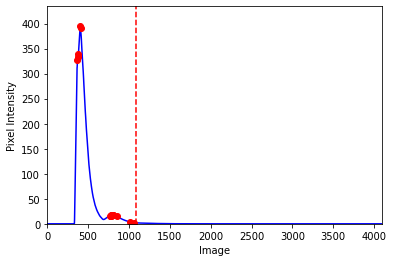

In [37]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Open the hdf5 file and read the images
with h5py.File(file, 'r') as f:
    images = np.array(f['H'])
    

# Get the number of images and the image dimensions
num_images, height, width = images.shape

# Create a figure with a single axis
fig, ax = plt.subplots()

# Loop through each image and plot a vertical line with a height proportional to the pixel intensity
max_val=0
intensities = []
for i in range(num_images):
    intensity = np.sum(images[i]) / (height * width)  # calculate the average pixel intensity for the image
    intensities.append(intensity)
    if intensity > max_val:
        max_val=intensity

# Smooth the intensity values using a moving average filter
window_size = 3
kernel = np.ones(window_size) / window_size
intensities_smooth = np.convolve(intensities, kernel, mode='same')

# Find all the local maxima in the smoothed intensities
peaks, _ = find_peaks(intensities_smooth,height=2)
small_peaks,_= find_peaks(intensities_smooth)
print(peaks)
print(small_peaks)

#Find the last peak
end_peak=np.where(small_peaks==peaks[-1])[0][0]+1
last_peak=small_peaks[end_peak]


# Plot the smoothed intensity values and the local maxima as red dots
ax.plot(np.arange(num_images), intensities_smooth, 'b')
ax.plot(peaks, intensities_smooth[peaks], 'ro')
ax.axvline(last_peak, color='r', linestyle='--')  # Vertical line at x=x_point


# Set the axis labels and limits
ax.set_xlabel('Image')
ax.set_ylabel('Pixel Intensity')
ax.set_xlim(-0.5, num_images - 0.5)  # set the x-axis limits to include all the images
ax.set_ylim(0, max_val*1.1)  # set the y-axis limits to the maximum pixel intensity in the images

# Show the plot
plt.show()


## 3. Eliminate not relevant info after last peak

### Average pooling downsampling technique

In [38]:
import numpy as np

# Assuming input_image is your 64x64xN image
N=last_peak
data_new=data[:,:,:N]
input_image =  data_new+ 1j*data_new
print(N,small_peaks)

# Determine pooling size
pooling_size = N // 64
remainder = N % 64

# If N is not an exact multiple of 64
if remainder != 0:
    input_image = input_image[:, :, :-remainder]

# Reshape to prepare for pooling
reshaped_image = input_image.reshape(64, 64, 64, pooling_size)

# Perform average pooling across the last dimension
g_new_2 = reshaped_image.mean(axis=-1)

g_new_2.shape

1092 [ 370  374  380  403  407  766  776  780  782  784  790  796  801  805
  807  848 1013 1063 1092 1096 1100 1105 1114 1125 1133 1137 1142 1149
 1154 1163 1167 1175 1177 1179 1186 1190 1199 1205 1209 1214 1216 1218
 1223 1227 1233 1239 1245 1253 1257 1259 1263 1267 1271 1275 1280 1289
 1297 1304 1309 1315 1317 1322 1324 1326 1333 1340 1344 1348 1354 1358
 1362 1364 1366 1372 1377 1387 1392 1402 1412 1419 1423 1428 1430 1432
 1436 1446 1450 1460 1466 1472 1474 1476 1480 1482 1487 1489 1492 1494
 1496 1503 1508 1510 1512 1517 1519 1521 1523 1525 1533 1540 1547 1549
 1553 1557 1559 1561 1563 1568 1572 1575 1577 1579 1581 1586 1590 1592
 1597 1599 1601 1603 1605 1607 1612 1616 1624 1626 1630 1634 1638 1641
 1644 1649 1656 1658 1665 1673 1679 1684 1686 1689 1694 1701 1704 1708
 1712 1715 1717 1721 1723 1726 1728 1730 1732 1735 1737 1742 1748 1751
 1755 1758 1765 1767 1771 1780 1782 1784 1787 1789 1795 1798 1802 1807
 1809 1815 1821 1827 1832 1834 1837 1841 1846 1851 1855 1862 1866 1870
 

(64, 64, 64)

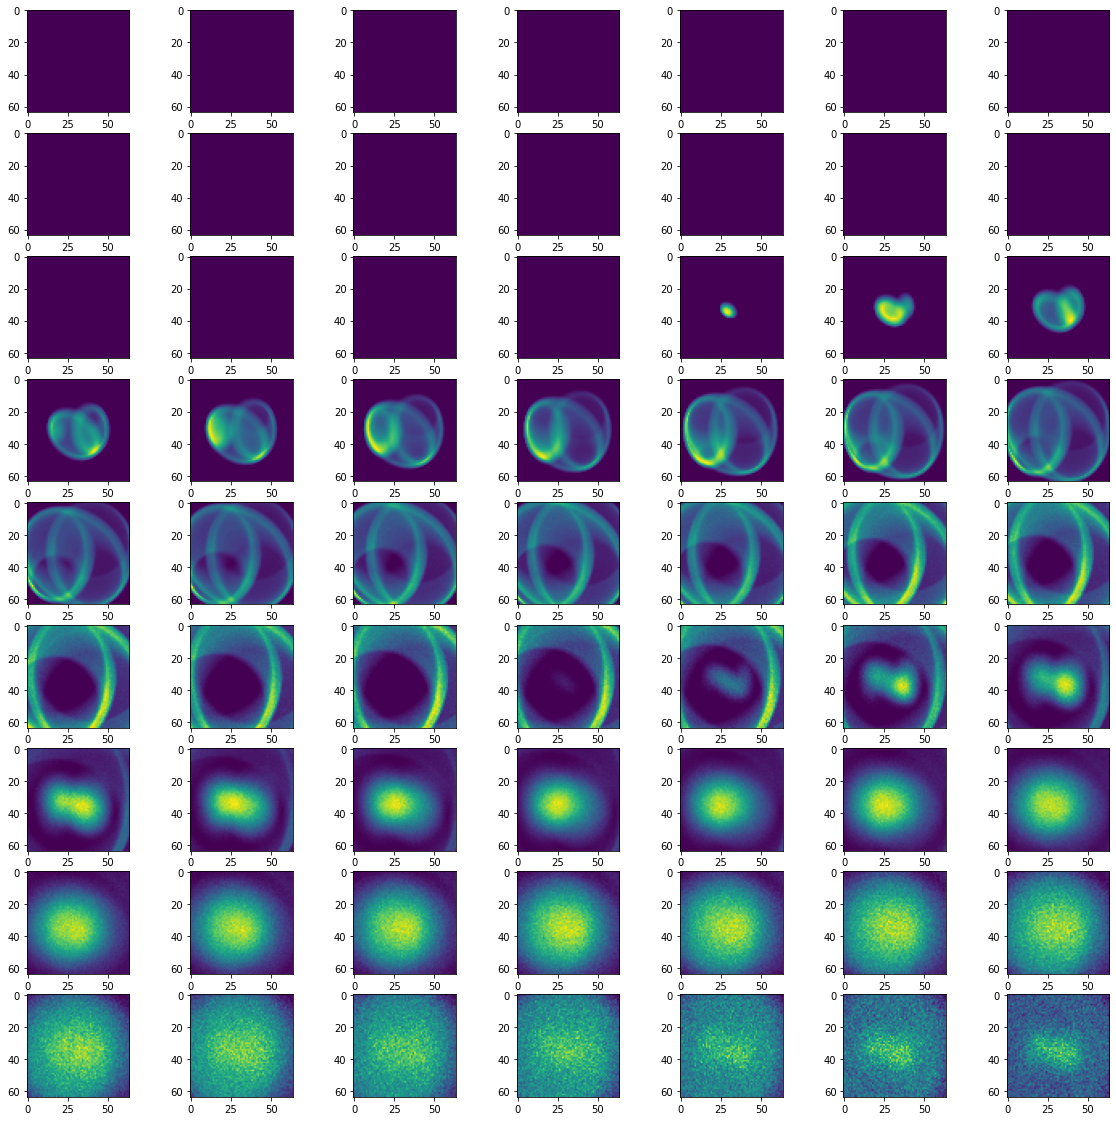

(64, 64, 64) 5443.670146019566 0j


In [39]:
#PLOT AFTER IMAGE REDUCTION + PCA COMPRESSION

import numpy as np
import matplotlib.pyplot as plt

# g_new_2=np.load("./validation/feature/bunny/x_0.0_y_-0.15_z_0.5_r_0.0.npy")
g_new_2=g_new_2
# Plot multiple images
row, col = 9,7
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(g_new_2[..., 0 + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()

print(g_new_2.shape,abs(g_new_2.max()), g_new_2.min())

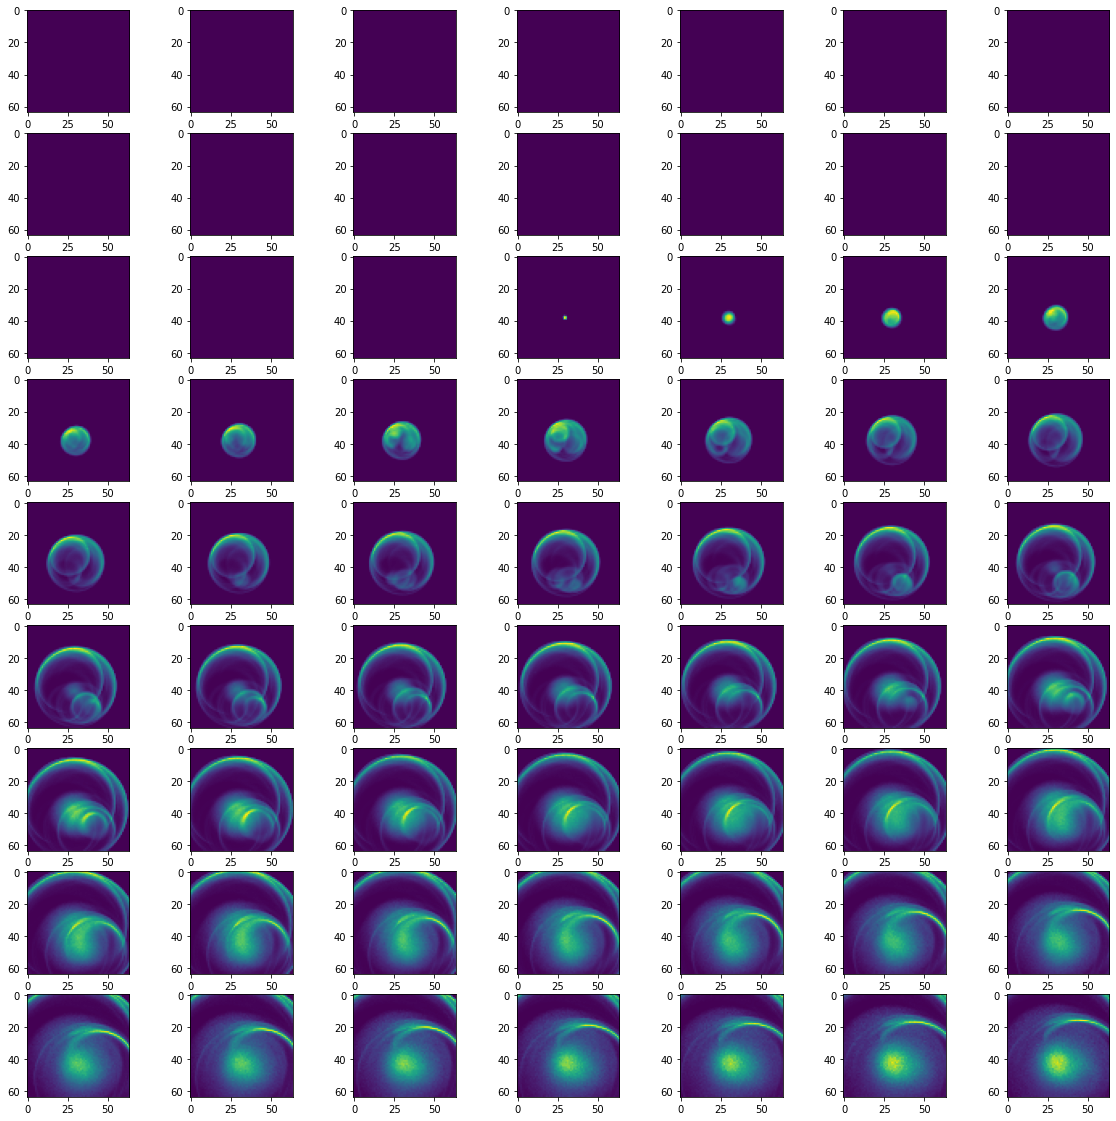

(64, 64, 64) 1856.551071525627 0j


In [23]:
import numpy as np
import matplotlib.pyplot as plt

g_new_2=np.load("./validation/feature/bunny/x_0.3_y_0.09_z_0.5_r_0.0.npy")
g_new_2=g_new_2
# Plot multiple images
row, col = 9,7
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(g_new_2[..., 0 + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()

print(g_new_2.shape,abs(g_new_2.max()), g_new_2.min())

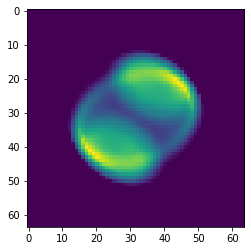

4741.846498038146


In [15]:
img = np.abs(g_new_2[...,22])
plt.imshow(img)
plt.show()
print(img.max())

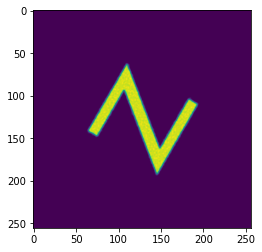

In [17]:

import numpy as np
import matplotlib.pyplot as plt

g_new_2=np.load("./train/target/Z/x_0.0_y_0.0_z_0.5_r_60.0_target.npy")
# Plot multiple images
img_p=plt.imshow(g_new_2)
plt.show()

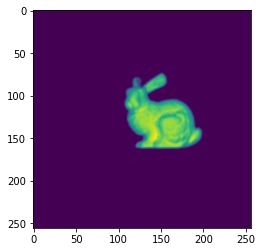

In [24]:
import numpy as np
import matplotlib.pyplot as plt

g_new_2=np.load("./train/target/bunny/x_0.3_y_0.09_z_0.75_r_0.0_target.npy")
# Plot multiple images
img_p=plt.imshow(g_new_2)
plt.show()

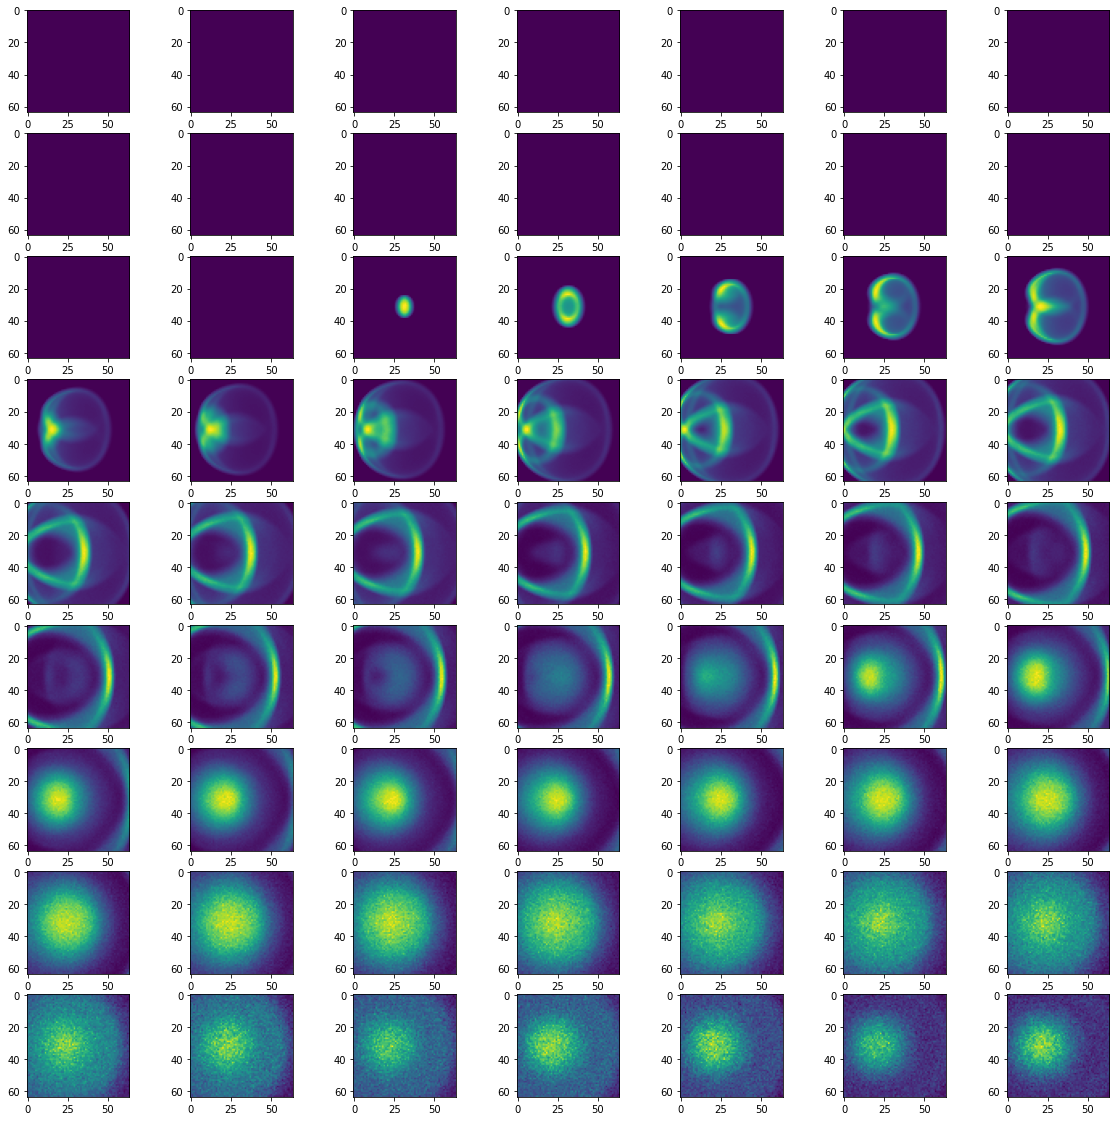

In [4]:
#CONFOCAL
import numpy as np
import matplotlib.pyplot as plt

g_new_2=np.load("./train/feature/square_hole/x_0.15_y_-0.3_z_0.5_r_0.0.npy")
# Plot multiple images
row, col = 9, 7
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(g_new_2[..., 0 + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()

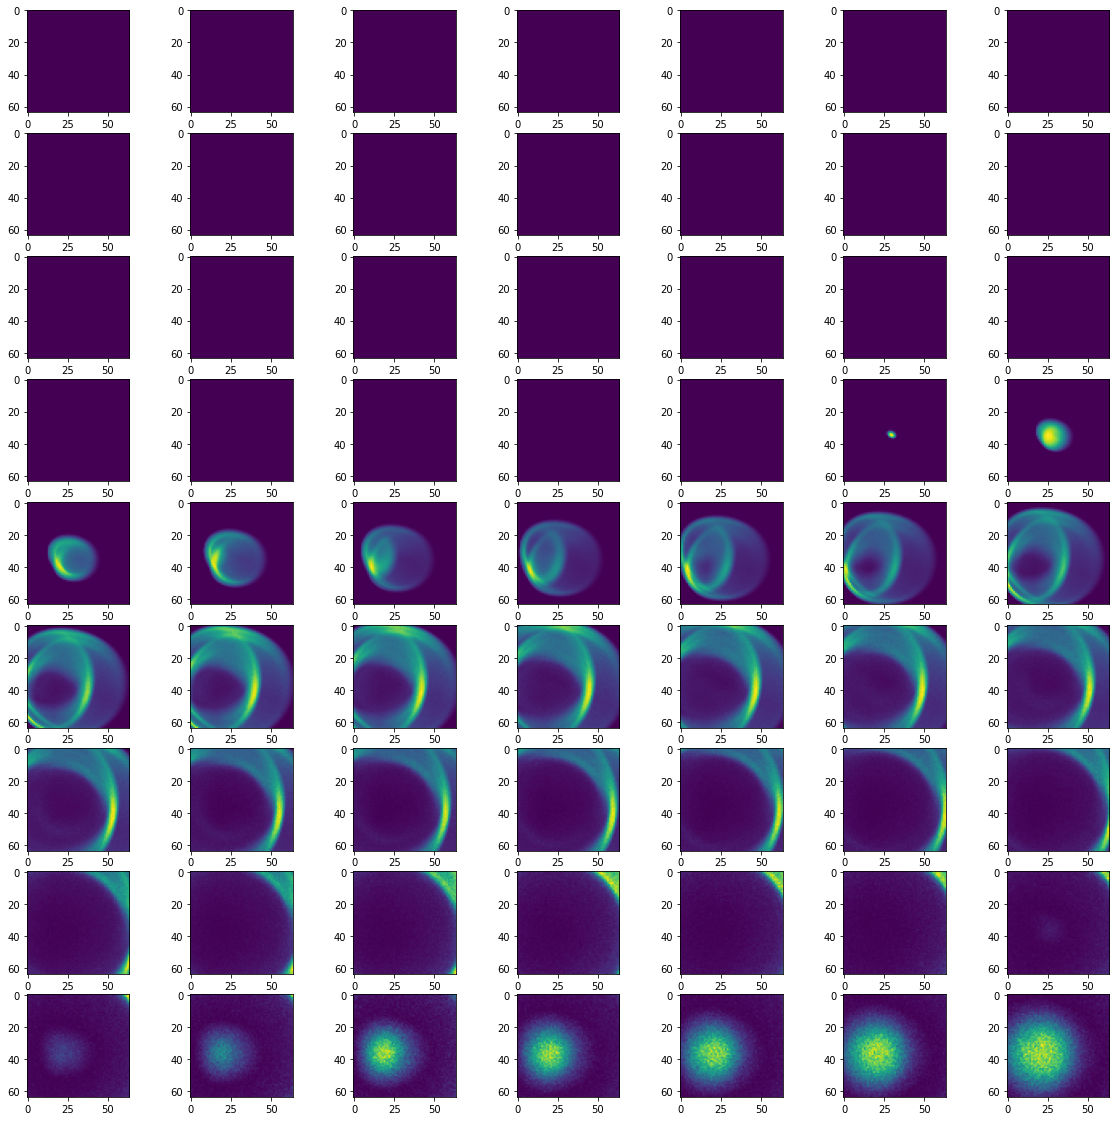

In [26]:
import numpy as np
import matplotlib.pyplot as plt

g_new_2=np.load("./validation/feature/triangle_hole/x_0.15_y_-0.35_z_0.75_r_0.0.npy")
# Plot multiple images
row, col = 9, 7
fig = plt.figure(figsize=(20, 20))
for i in range(1, row * col + 1):
    img = np.abs(g_new_2[..., 0 + i])
    ax = plt.subplot(row, col, i)
    ax.imshow(img)

plt.show()